Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

File train: crc_x.csv
File test: crc_x.csv
ACC: 0.6596516690856313
AUC: 0.658518315018315
MCC: 0.3197133227906156

File train: crc_x.csv
File test: feng_x.csv
ACC: 0.7336363636363636
AUC: 0.7276190476190476
MCC: 0.4908250155118374

File train: crc_x.csv
File test: vogtmann_x.csv
ACC: 0.58
AUC: 0.5716666666666668
MCC: 0.1428352819880647

File train: crc_x.csv
File test: zeller_x.csv
ACC: 0.7291666666666666
AUC: 0.7125992063492064
MCC: 0.4614470350659231

File train: crc_x.csv
File test: yu_x.csv
ACC: 0.6183823529411765
AUC: 0.6065674603174603
MCC: 0.22426299843139894


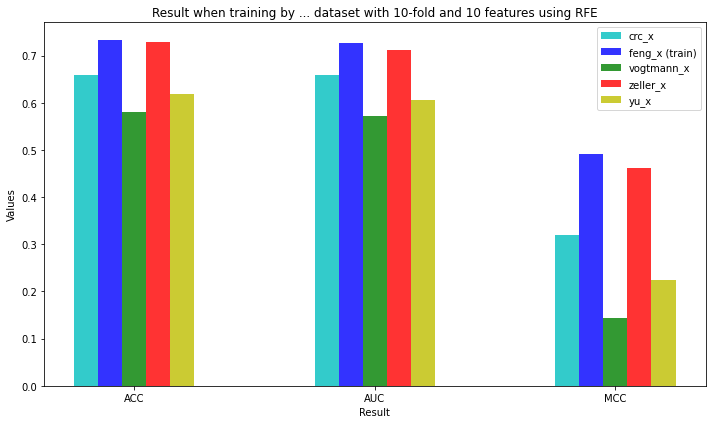

In [57]:
import csv
import pandas as pd
import os.path
from os import listdir
from tabulate import tabulate
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from google.colab import drive
from sklearn.svm import SVR
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas_profiling

from matplotlib import rcParams
import warnings
import statistics


# Creating a new figure, with width and height in inches
rcParams["figure.figsize"] = 10, 6

# np.random.seed(12)

# Mount the content, read dataset (csv files) from drive and store all the path into the list
drive.mount('/content/drive')
data_list = listdir('/content/drive/My Drive/Bacterial_Dataset/Other')

###
### Set the number of feature that needs to be extracted from csv files
###
NUMBER_of_FEATURE = 10

# Store the ACC, AUC and MCC results of each test dataset into the list
list_result = []

# Test each file based on the path in the data list (each file in the folder)
for file_test_path in data_list:

  ###
  ### Get the file_train path (based on the index of that file in the folder)
  ###
  file_train = data_list[0]

  X1 = pd.read_csv('/content/drive/My Drive/Bacterial_Dataset/Other/' + file_train, usecols=lambda col : col not in ['RS'])
  Y1 = pd.read_csv('/content/drive/My Drive/Bacterial_Dataset/Other/' + file_train, usecols=['RS']).values[:,0]
  del X1['Unnamed: 0']
  #print(tabulate(X1, headers='keys', tablefmt='psql'))

  # Select number of features
  selector = RFE(estimator=SVR(kernel="linear"), n_features_to_select=NUMBER_of_FEATURE, step=1)
  selector = selector.fit(X1, Y1)

  # Extract features based on the results into the RS list
  feature_index = []
  features = []
  for num, i in enumerate(selector.get_support(), start=0):
      if i:
          feature_index.append(str(num))

  for num, i in enumerate(X1.columns.values, start=0):
      if str(num) in feature_index:
          features.append(X1.columns.values[num])


  RS = []
  for i in range(len(feature_index)):
    RS.append(features[i])

  # Get the file test based on the path when iterating
  file_test = file_test_path

  y = pd.read_csv('/content/drive/My Drive/Bacterial_Dataset/Other/' + file_test, usecols=['RS'])
  X = pd.read_csv('/content/drive/My Drive/Bacterial_Dataset/Other/' + file_test, usecols=RS)

  # Standardize the dataset
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  ###
  ### KFold
  ###
  num_of_folds = 10
  kf = StratifiedKFold(n_splits=num_of_folds, shuffle=True, random_state=1)
  kf.get_n_splits(X_scaled)
  #y = y.transpose()

  # Store the result of each fold into the list
  ACC_list = []
  AUC_list = []
  MCC_list = []

  for train_index, test_index in kf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y = y.transpose()
    y_train, y_test = y[train_index], y[test_index]
    y_train = y_train.transpose()
    y_test = y_test.transpose()
    y = y.transpose()

    classifier = RandomForestClassifier(n_estimators=100)
    classifier.fit(X_train, y_train.values.ravel())
    y_pred = classifier.predict(X_test)
    y_pred = pd.DataFrame(data=y_pred)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)

    acc_score = accuracy_score(y_test, y_pred)
    auc_score = metrics.auc(fpr, tpr)
    mcc_score = matthews_corrcoef(y_test, y_pred)

    ACC_list.append(acc_score)
    AUC_list.append(auc_score)
    MCC_list.append(mcc_score)

  # Get mean value from k-fold
  list_result.append([statistics.mean(ACC_list), statistics.mean(AUC_list), statistics.mean(MCC_list)])
  print("\nFile train: " + file_train)
  print("File test: " + file_test)
  print('ACC:', statistics.mean(ACC_list))
  print('AUC:', statistics.mean(AUC_list))
  print('MCC:', statistics.mean(MCC_list))



# Draw bar graph
n_groups = 3
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.8

rect1 = plt.bar(index, list_result[0], bar_width, alpha = opacity, color = 'c', label = 'crc_x')
rect2 = plt.bar(index + bar_width, list_result[1], bar_width, alpha = opacity, color = 'b', label = 'feng_x (train)')
rect3 = plt.bar(index + 2 * bar_width, list_result[2], bar_width, alpha = opacity, color = 'g', label = 'vogtmann_x')
rect4 = plt.bar(index + 3 * bar_width, list_result[3], bar_width, alpha = opacity, color = 'r', label = 'zeller_x')
rect5 = plt.bar(index + 4 * bar_width, list_result[4], bar_width, alpha = opacity, color = 'y', label = 'yu_x')
#rect6 = plt.bar(index + 5 * bar_width, list_result[5], bar_width, alpha = opacity, color = 'm', label = 'iCDr_x')

plt.xlabel('Result')
plt.ylabel('Values')
plt.title('Result when training by ... dataset with ' + str(num_of_folds) + '-fold and '  + str(NUMBER_of_FEATURE) + ' features using RFE')
plt.xticks(index + 2 * bar_width, ('ACC', 'AUC', 'MCC'))
plt.legend()
plt.tight_layout()
plt.show()




File train: crc_x.csv
File test: crc_x.csv
ACC: 0.5645863570391872
AUC: 0.562899063899064
MCC: 0.12668263311182595

File train: crc_x.csv
File test: feng_x.csv
ACC: 0.6145454545454545
AUC: 0.5966666666666667
MCC: 0.20698460708916105

File train: crc_x.csv
File test: vogtmann_x.csv
ACC: 0.58
AUC: 0.5808333333333333
MCC: 0.17242526987743548

File train: crc_x.csv
File test: zeller_x.csv
ACC: 0.7233333333333334
AUC: 0.7133928571428572
MCC: 0.432873460102415

File train: crc_x.csv
File test: yu_x.csv
ACC: 0.5213235294117647
AUC: 0.5081944444444445
MCC: 0.01667151635524332


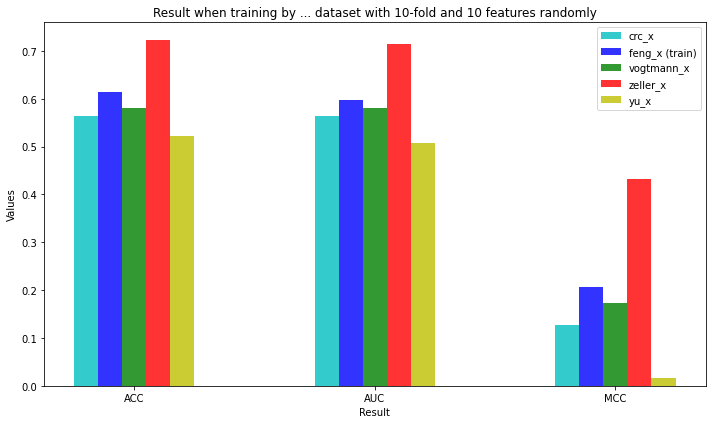

In [58]:
import random

###
### Set the number of feature that needs to be extracted from csv files
###
NUMBER_of_FEATURE = 10

# Store the ACC, AUC and MCC results of each test dataset into the list
list_result = []

# Test each file based on the path in the data list (each file in the folder)
for file_test_path in data_list:

  ###
  ### Get the file_train path (based on the index of that file in the folder)
  ###
  file_train = data_list[0]

  X1 = pd.read_csv('/content/drive/My Drive/Bacterial_Dataset/Other/' + file_train, usecols=lambda col : col not in ['RS'])
  Y1 = pd.read_csv('/content/drive/My Drive/Bacterial_Dataset/Other/' + file_train, usecols=['RS']).values[:,0]
  del X1['Unnamed: 0']
  #print(tabulate(X1, headers='keys', tablefmt='psql'))

  # Extract features based on the results into the RS list
  feature_index = []
  features = []

  set_random_value = set()
  while len(set_random_value) < NUMBER_of_FEATURE:
        set_random_value.add(str(random.randint(10, 1900)))
  feature_index = list(set_random_value)

  for num, i in enumerate(X1.columns.values, start=0):
      if str(num) in feature_index:
          features.append(X1.columns.values[num])

  RS = []
  for i in range(len(feature_index)):
    RS.append(features[i])

  # Get the file test based on the path when iterating
  file_test = file_test_path

  y = pd.read_csv('/content/drive/My Drive/Bacterial_Dataset/Other/' + file_test, usecols=['RS'])
  X = pd.read_csv('/content/drive/My Drive/Bacterial_Dataset/Other/' + file_test, usecols=RS)

  # Standardize the dataset
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  ###
  ### KFold
  ###
  num_of_folds = 10
  kf = StratifiedKFold(n_splits=num_of_folds, shuffle=True, random_state=1)
  kf.get_n_splits(X_scaled)
  #y = y.transpose()

  # Store the result of each fold into the list
  ACC_list = []
  AUC_list = []
  MCC_list = []

  for train_index, test_index in kf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y = y.transpose()
    y_train, y_test = y[train_index], y[test_index]
    y_train = y_train.transpose()
    y_test = y_test.transpose()
    y = y.transpose()

    classifier = RandomForestClassifier(n_estimators=100)
    classifier.fit(X_train, y_train.values.ravel())
    y_pred = classifier.predict(X_test)
    y_pred = pd.DataFrame(data=y_pred)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)

    acc_score = accuracy_score(y_test, y_pred)
    auc_score = metrics.auc(fpr, tpr)
    mcc_score = matthews_corrcoef(y_test, y_pred)

    ACC_list.append(acc_score)
    AUC_list.append(auc_score)
    MCC_list.append(mcc_score)

  # Get mean value from k-fold
  list_result.append([statistics.mean(ACC_list), statistics.mean(AUC_list), statistics.mean(MCC_list)])
  print("\nFile train: " + file_train)
  print("File test: " + file_test)
  print('ACC:', statistics.mean(ACC_list))
  print('AUC:', statistics.mean(AUC_list))
  print('MCC:', statistics.mean(MCC_list))



# Draw bar graph
n_groups = 3
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.8

rect1 = plt.bar(index, list_result[0], bar_width, alpha = opacity, color = 'c', label = 'crc_x')
rect2 = plt.bar(index + bar_width, list_result[1], bar_width, alpha = opacity, color = 'b', label = 'feng_x (train)')
rect3 = plt.bar(index + 2 * bar_width, list_result[2], bar_width, alpha = opacity, color = 'g', label = 'vogtmann_x')
rect4 = plt.bar(index + 3 * bar_width, list_result[3], bar_width, alpha = opacity, color = 'r', label = 'zeller_x')
rect5 = plt.bar(index + 4 * bar_width, list_result[4], bar_width, alpha = opacity, color = 'y', label = 'yu_x')
#rect6 = plt.bar(index + 5 * bar_width, list_result[5], bar_width, alpha = opacity, color = 'm', label = 'iCDr_x')

plt.xlabel('Result')
plt.ylabel('Values')
plt.title('Result when training by ... dataset with ' + str(num_of_folds) + '-fold and '  + str(NUMBER_of_FEATURE) + ' features randomly')
plt.xticks(index + 2 * bar_width, ('ACC', 'AUC', 'MCC'))
plt.legend()
plt.tight_layout()
plt.show()
